In [58]:
import os
import pandas as pd
import numpy as np
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
  
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    

def to_sequences(seq_size, df ,data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = df[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        #window = [[x] for x in window]
       #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
  
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
 
  # Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [59]:
path=os.getcwd() #+ "\Data"
path
files=os.listdir(path)
files

['.ipynb_checkpoints',
 'Emission.ipynb',
 'emissions_by_unit_and_fuel_type_c_d_aa_2_20_2019.xlsx',
 'Emission_Cooling_FacilityId.xlsx',
 'Generation_Yearly _For_Emission.xlsx',
 'ghgrp_oris_power_plant_crosswalk_8_5_17+TB+JF.xlsx',
 'pre_processed.xlsx',
 '~$Emission_Cooling_FacilityId.xlsx']

In [5]:
f = 'emissions_by_unit_and_fuel_type_c_d_aa_2_20_2019.xlsx'
df_emission = pd.read_excel(f, sheet_name=0, header=5, sort=False, encoding="utf-8")

In [23]:
df_emission

,Facility Id,FRS Id,Facility Name,City,State,Primary NAICS Code,Reporting Year,Industry Type (subparts),Industry Type (sectors),Unit Name,Unit Type,Unit Reporting Method,Unit Maximum Rated Heat Input (mmBTU/hr),Unit CO2 emissions (non-biogenic),Unit Methane (CH4) emissions (mt CO2e),Unit Nitrous Oxide (N2O) emissions (mt CO2e),Unit Biogenic CO2 emissions (metric tons)
0,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211130,2017,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.000,9106.1,4.25,5.066,0.0
1,1012147,NaN,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,211112,2016,"C,NN,W","Natural Gas and Natural Gas Liquids Suppliers,...",CP-03.00,OCS (Other combustion source),Tier1/2/3,30.000,9922.2,4.75,5.662,0.0
2,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,2301,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,30433.6,14.00,17.880,0.0
3,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,2302,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,22146.9,10.25,11.920,0.0
4,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,Heatec1,PRH (Process Heater),Tier1/2/3,7.400,32.5,0.00,0.000,0.0
5,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2017,"C,D",Power Plants,Heatec2,PRH (Process Heater),Tier1/2/3,7.400,32.5,0.00,0.000,0.0
6,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,2301,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,34949.2,16.25,20.860,0.0
7,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,2302,Electricity Generator,"Tier4, Alt-P75 or P75",NaN,31723.0,14.75,17.880,0.0
8,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,Heatec1,PRH (Process Heater),Tier1/2/3,7.400,32.4,0.00,0.000,0.0
9,1000112,1.100438e+11,23rd and 3rd,BROOKLYN,NY,221112,2016,"C,D",Power Plants,Heatec2,PRH (Process Heater),Tier1/2/3,7.400,24.8,0.00,0.000,0.0


In [7]:
df_industry_type = pd.read_excel(f, sheet_name=2, header=1, sort=False, encoding="utf-8")

In [8]:
lst = df_industry_type["Subpart Letter"].unique()

In [9]:
df_test = pd.DataFrame(columns=lst)

In [10]:
df_test

,C,D,E,F,G,H,I,K,L,N,...,NN,NN-FRAC,NN-LDC,OO,PP,QQ,RR,SS,TT,UU


In [12]:
df_concatenated = df_emission.append(df_test, sort=False)

In [25]:
#df_concatenated=df_concatenated.drop(df_concatenated[151437:], axis=0)
df_concatenated = df_concatenated.drop(df_concatenated.index[[151437,151491]])

In [26]:
new = df_concatenated["Industry Type (subparts)"].str.split(",", expand = True)
new

,0,1,2,3,4,5
0,C,NN,W,None,None,None
1,C,NN,W,None,None,None
2,C,D,None,None,None,None
3,C,D,None,None,None,None
4,C,D,None,None,None,None
5,C,D,None,None,None,None
6,C,D,None,None,None,None
7,C,D,None,None,None,None
8,C,D,None,None,None,None
9,C,D,None,None,None,None


In [47]:
for idx, row in new.iterrows():
    for x in range(6):
        if new.loc[idx, x] != None:
            s=new.loc[idx, x]
            df_concatenated.loc[idx, s] = 1

In [54]:
FT = df_industry_type["Facility Type"].unique()

In [55]:
df_temp = pd.DataFrame(columns=FT)

In [56]:
df_temp

,Direct Emitter,Onshore Oil & Gas Production,Gathering & Boosting,Transmission Pipelines,LDC - Direct Emissions,SF6 from Elec. Equip.,Supplier,CO2 Injection


In [78]:
df_concatenated.dtypes

Facility Id                                     float64
FRS Id                                          float64
Facility Name                                    object
City                                             object
State                                            object
Primary NAICS Code                              float64
Reporting Year                                  float64
Industry Type (subparts)                         object
Industry Type (sectors)                          object
Unit Name                                        object
Unit Type                                        object
Unit Reporting Method                            object
Unit Maximum Rated Heat Input (mmBTU/hr)        float64
Unit CO2 emissions (non-biogenic)               float64
Unit Methane (CH4) emissions (mt CO2e)          float64
Unit Nitrous Oxide (N2O) emissions (mt CO2e)    float64
Unit Biogenic CO2 emissions (metric tons)       float64
AA                                              

In [65]:
df_concatenated = df_concatenated.drop('Facility Type', axis=1)
df_concatenated = df_concatenated.drop('Name of industry', axis=1)
df_concatenated = df_concatenated.drop('Subpart Letter', axis=1)

In [67]:
df_concatenated = df_concatenated.append(df_temp, sort=False)

In [80]:
df_concatenated['C'] = pd.to_numeric(df_concatenated['C'], errors='coerce')
df_concatenated['D'] = pd.to_numeric(df_concatenated['D'], errors='coerce')
df_concatenated['E'] = pd.to_numeric(df_concatenated['E'], errors='coerce')
df_concatenated['F'] = pd.to_numeric(df_concatenated['F'], errors='coerce')
df_concatenated['G'] = pd.to_numeric(df_concatenated['G'], errors='coerce')
df_concatenated['H'] = pd.to_numeric(df_concatenated['H'], errors='coerce')
df_concatenated['I'] = pd.to_numeric(df_concatenated['I'], errors='coerce')
df_concatenated['K'] = pd.to_numeric(df_concatenated['K'], errors='coerce')
df_concatenated['L'] = pd.to_numeric(df_concatenated['L'], errors='coerce')
df_concatenated['N'] = pd.to_numeric(df_concatenated['N'], errors='coerce')
df_concatenated['O'] = pd.to_numeric(df_concatenated['O'], errors='coerce')
df_concatenated['P'] = pd.to_numeric(df_concatenated['P'], errors='coerce')
df_concatenated['Q'] = pd.to_numeric(df_concatenated['Q'], errors='coerce')
df_concatenated['R'] = pd.to_numeric(df_concatenated['R'], errors='coerce')
df_concatenated['S'] = pd.to_numeric(df_concatenated['S'], errors='coerce')
df_concatenated['T'] = pd.to_numeric(df_concatenated['T'], errors='coerce')
df_concatenated['U'] = pd.to_numeric(df_concatenated['U'], errors='coerce')
df_concatenated['V'] = pd.to_numeric(df_concatenated['V'], errors='coerce')
df_concatenated['W'] = pd.to_numeric(df_concatenated['W'], errors='coerce')
df_concatenated['W-ONSH'] = pd.to_numeric(df_concatenated['W-ONSH'], errors='coerce')
df_concatenated['W-GB'] = pd.to_numeric(df_concatenated['W-GB'], errors='coerce')
df_concatenated['W-PROC'] = pd.to_numeric(df_concatenated['W-PROC'], errors='coerce')
df_concatenated['W-NGTC'] = pd.to_numeric(df_concatenated['W-NGTC'], errors='coerce')
df_concatenated['W-TRANS'] = pd.to_numeric(df_concatenated['W-TRANS'], errors='coerce')
df_concatenated['W-UNSTG'] = pd.to_numeric(df_concatenated['W-UNSTG'], errors='coerce')
df_concatenated['W-LNGSTG'] = pd.to_numeric(df_concatenated['W-LNGSTG'], errors='coerce')
df_concatenated['W-LNGIE'] = pd.to_numeric(df_concatenated['W-LNGIE'], errors='coerce')
df_concatenated['W-LDC'] = pd.to_numeric(df_concatenated['W-LDC'], errors='coerce')
df_concatenated['X'] = pd.to_numeric(df_concatenated['X'], errors='coerce')
df_concatenated['Y'] = pd.to_numeric(df_concatenated['Y'], errors='coerce')
df_concatenated['Z'] = pd.to_numeric(df_concatenated['Z'], errors='coerce')
df_concatenated['AA'] = pd.to_numeric(df_concatenated['AA'], errors='coerce')
df_concatenated['BB'] = pd.to_numeric(df_concatenated['BB'], errors='coerce')
df_concatenated['CC'] = pd.to_numeric(df_concatenated['CC'], errors='coerce')
df_concatenated['DD'] = pd.to_numeric(df_concatenated['DD'], errors='coerce')
df_concatenated['EE'] = pd.to_numeric(df_concatenated['EE'], errors='coerce')
df_concatenated['FF'] = pd.to_numeric(df_concatenated['FF'], errors='coerce')
df_concatenated['GG'] = pd.to_numeric(df_concatenated['GG'], errors='coerce')
df_concatenated['HH'] = pd.to_numeric(df_concatenated['HH'], errors='coerce')
df_concatenated['II'] = pd.to_numeric(df_concatenated['II'], errors='coerce')
df_concatenated['LL'] = pd.to_numeric(df_concatenated['LL'], errors='coerce')
df_concatenated['MM'] = pd.to_numeric(df_concatenated['MM'], errors='coerce')
df_concatenated['MM – REF'] = pd.to_numeric(df_concatenated['MM – REF'], errors='coerce')
df_concatenated['MM – IMP'] = pd.to_numeric(df_concatenated['MM – IMP'], errors='coerce')
df_concatenated['MM – EXP'] = pd.to_numeric(df_concatenated['MM – EXP'], errors='coerce')
df_concatenated['NN'] = pd.to_numeric(df_concatenated['NN'], errors='coerce')
df_concatenated['NN-FRAC'] = pd.to_numeric(df_concatenated['NN-FRAC'], errors='coerce')
df_concatenated['NN-LDC'] = pd.to_numeric(df_concatenated['NN-LDC'], errors='coerce')
df_concatenated['OO'] = pd.to_numeric(df_concatenated['OO'], errors='coerce')
df_concatenated['PP'] = pd.to_numeric(df_concatenated['PP'], errors='coerce')
df_concatenated['QQ'] = pd.to_numeric(df_concatenated['QQ'], errors='coerce')
df_concatenated['RR'] = pd.to_numeric(df_concatenated['RR'], errors='coerce')
df_concatenated['SS'] = pd.to_numeric(df_concatenated['SS'], errors='coerce')
df_concatenated['TT'] = pd.to_numeric(df_concatenated['TT'], errors='coerce')
df_concatenated['UU'] = pd.to_numeric(df_concatenated['UU'], errors='coerce')
df_concatenated['Direct Emitter'] = pd.to_numeric(df_concatenated['Direct Emitter'], errors='coerce')
df_concatenated['Onshore Oil & Gas Production'] = pd.to_numeric(df_concatenated['Onshore Oil & Gas Production'], errors='coerce')
df_concatenated['Gathering & Boosting'] = pd.to_numeric(df_concatenated['Gathering & Boosting'], errors='coerce')
df_concatenated['Transmission Pipelines'] = pd.to_numeric(df_concatenated['Transmission Pipelines'], errors='coerce')
df_concatenated['LDC - Direct Emissions'] = pd.to_numeric(df_concatenated['LDC - Direct Emissions'], errors='coerce')
df_concatenated['SF6 from Elec. Equip.'] = pd.to_numeric(df_concatenated['SF6 from Elec. Equip.'], errors='coerce')
df_concatenated['Supplier'] = pd.to_numeric(df_concatenated['Supplier'], errors='coerce')
df_concatenated['CO2 Injection'] = pd.to_numeric(df_concatenated['CO2 Injection'], errors='coerce')           

In [82]:
for idx, row in df_concatenated.iterrows():
    if(df_concatenated.loc[idx,'C']==1 | df_concatenated.loc[idx,'D']==1 | df_concatenated.loc[idx,'E']==1 | df_concatenated.loc[idx,'F']==1 | df_concatenated.loc[idx,'G']==1 | df_concatenated.loc[idx,'H']==1 | df_concatenated.loc[idx,'I']==1 | df_concatenated.loc[idx,'K']==1 | df_concatenated.loc[idx,'L']==1 | df_concatenated.loc[idx,'N']==1 | df_concatenated.loc[idx,'O']==1 | df_concatenated.loc[idx,'P']==1 | df_concatenated.loc[idx,'Q']==1 | df_concatenated.loc[idx,'R']==1 | df_concatenated.loc[idx,'S']==1 | df_concatenated.loc[idx,'T']==1 | df_concatenated.loc[idx,'U']==1 | df_concatenated.loc[idx,'V']==1 | df_concatenated.loc[idx,'W']==1 | df_concatenated.loc[idx,'W-OFFSH']==1 | df_concatenated.loc[idx,'W-PROC']==1 | df_concatenated.loc[idx,'W-NGTC']==1 | df_concatenated.loc[idx,'W-UNSTG']==1 | df_concatenated.loc[idx,'W-LNGSTG']==1 | df_concatenated.loc[idx,'W-LNGIE']==1 | df_concatenated.loc[idx,'X']==1 | df_concatenated.loc[idx,'Y']==1 | df_concatenated.loc[idx,'Z']==1 | df_concatenated.loc[idx,'AA']==1 | df_concatenated.loc[idx,'BB']==1 | df_concatenated.loc[idx,'CC']==1 | df_concatenated.loc[idx,'EE']==1 | df_concatenated.loc[idx,'FF']==1 | df_concatenated.loc[idx,'GG']==1 | df_concatenated.loc[idx,'HH']==1 | df_concatenated.loc[idx,'II']==1 | df_concatenated.loc[idx,'SS']==1 | df_concatenated.loc[idx,'TT']==1):
        df_concatenated.loc[idx,'Direct Emitter'] = 1
    if(df_concatenated.loc[idx,'RR']==1 | df_concatenated.loc[idx,'UU'] ==1):
        df_concatenated.loc[idx,'CO2 Injection'] = 1
    if(df_concatenated.loc[idx,'W-GB']==1):
        df_concatenated.loc[idx,'Gathering & Boosting'] = 1
    if(df_concatenated.loc[idx,'W-LDC']==1):
        df_concatenated.loc[idx,'LDC - Direct Emissions'] = 1
    if(df_concatenated.loc[idx,'W-ONSH']==1):
        df_concatenated.loc[idx,'Onshore Oil & Gas Production'] = 1
    if(df_concatenated.loc[idx,'DD']==1):
        df_concatenated.loc[idx,'SF6 from Elec. Equip.'] = 1
    if(df_concatenated.loc[idx,'DD']==1):
        df_concatenated.loc[idx,'SF6 from Elec. Equip.'] = 1
    if(df_concatenated.loc[idx,'LL']==1 | df_concatenated.loc[idx,'MM']==1 | df_concatenated.loc[idx,'MM – REF']==1 | df_concatenated.loc[idx,'MM – IMP']==1 | df_concatenated.loc[idx,'MM – EXP']==1 | df_concatenated.loc[idx,'NN']==1 | df_concatenated.loc[idx,'NN-FRAC']==1 | df_concatenated.loc[idx,'NN-LDC']==1 | df_concatenated.loc[idx,'OO']==1 | df_concatenated.loc[idx,'PP']==1 | df_concatenated.loc[idx,'QQ']==1):
        df_concatenated.loc[idx,'Supplier']=1
    if(df_concatenated.loc[idx,'W-TRANS']==1):
        df_concatenated.loc[idx,'Transmission Pipelines'] = 1

TypeError: unsupported operand type(s) for |: 'int' and 'numpy.float64'

# Fuel-Data and Generation

In [60]:
path=os.getcwd() #+ "\Data"
path
files=os.listdir(path)
files

['.ipynb_checkpoints',
 'Emission.ipynb',
 'emissions_by_unit_and_fuel_type_c_d_aa_2_20_2019.xlsx',
 'Emission_Cooling_FacilityId.xlsx',
 'Generation_Yearly _For_Emission.xlsx',
 'ghgrp_oris_power_plant_crosswalk_8_5_17+TB+JF.xlsx',
 'pre_processed.xlsx',
 '~$Emission_Cooling_FacilityId.xlsx']

In [77]:
f = 'Emission_Cooling_FacilityId.xlsx'
df_emi_cool = pd.read_excel(f, sheet_name=3, usecols="A,B,D,F,H,I,J,L,P,Q,R", header=0, sort=False, encoding="utf-8")

In [78]:
df_emi_cool.dtypes

Facility Id                                           int64
Plant Code                                           object
Facility Name                                        object
State                                                object
Reporting Year                                        int64
Industry Type (subparts)                             object
Industry Type (sectors)                              object
General Fuel Type                                    object
Fuel CO2 emissions (non-biogenic)  (metric tons)    float64
Fuel Methane (CH4) emissions (mt CO2e)              float64
Fuel Nitrous Oxide (N2O) emissions (mt CO2e)        float64
dtype: object

In [83]:
df_emi_cool.loc[(df_emi_cool['Industry Type (sectors)'] != 'Power Plants')]

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Fuel CO2 emissions (non-biogenic) (metric tons),Fuel Methane (CH4) emissions (mt CO2e),Fuel Nitrous Oxide (N2O) emissions (mt CO2e)


In [82]:
df_emi_cool=df_emi_cool[~(df_emi_cool['Industry Type (sectors)'] != 'Power Plants')]

In [84]:
# Renaming attributes
df_emi_cool.rename(columns={'Fuel CO2 emissions (non-biogenic)  (metric tons)': 'Fuel_CO2_Emissions', 
                            'Fuel Methane (CH4) emissions (mt CO2e)': 'Fuel_Methan_CH4_Emissions',
                            'Fuel Nitrous Oxide (N2O) emissions (mt CO2e)':'Fuel_Nitrous_Oxide_N2O_Emissions'}, inplace=True);

In [85]:
df_Emission_Gen = df_emi_cool

In [86]:
df_Emission_Gen['Total_Emission']=df_Emission_Gen['Fuel_CO2_Emissions']+df_Emission_Gen['Fuel_Methan_CH4_Emissions']+df_Emission_Gen['Fuel_Nitrous_Oxide_N2O_Emissions']

In [87]:
df_Emission_Gen

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Fuel_CO2_Emissions,Fuel_Methan_CH4_Emissions,Fuel_Nitrous_Oxide_N2O_Emissions,Total_Emission
2,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,30433.60,14.00,17.88,30465.48
3,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,22146.90,10.25,11.92,22169.07
4,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,32.50,0.00,0.00,32.50
5,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,32.50,0.00,0.00,32.50
6,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,34949.20,16.25,20.86,34986.31
7,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,31723.00,14.75,17.88,31755.63
8,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,32.40,0.00,0.00,32.40
9,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,24.80,0.00,0.00,24.80
10,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,35203.30,16.25,20.86,35240.41
11,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,31996.00,14.75,17.88,32028.63


In [88]:
d=df_Emission_Gen.dropna(subset=['Plant Code'])

In [92]:
d.loc[(d['Plant Code'] == 'No Match')]

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Fuel_CO2_Emissions,Fuel_Methan_CH4_Emissions,Fuel_Nitrous_Oxide_N2O_Emissions,Total_Emission


In [90]:
d=d[~(d['Plant Code'] == 'No Match')]

In [91]:
d

,Facility Id,Plant Code,Facility Name,State,Reporting Year,Industry Type (subparts),Industry Type (sectors),General Fuel Type,Fuel_CO2_Emissions,Fuel_Methan_CH4_Emissions,Fuel_Nitrous_Oxide_N2O_Emissions,Total_Emission
2,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,30433.60,14.00,17.88,30465.48
3,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,22146.90,10.25,11.92,22169.07
4,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,32.50,0.00,0.00,32.50
5,1000112,7910,23rd and 3rd,NY,2017,"C,D",Power Plants,Natural Gas,32.50,0.00,0.00,32.50
6,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,34949.20,16.25,20.86,34986.31
7,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,31723.00,14.75,17.88,31755.63
8,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,32.40,0.00,0.00,32.40
9,1000112,7910,23rd and 3rd,NY,2016,"C,D",Power Plants,Natural Gas,24.80,0.00,0.00,24.80
10,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,35203.30,16.25,20.86,35240.41
11,1000112,7910,23rd and 3rd,NY,2015,"C,D",Power Plants,Natural Gas,31996.00,14.75,17.88,32028.63


In [93]:
d=d.drop(['Fuel_CO2_Emissions', 'Fuel_Methan_CH4_Emissions', 'Fuel_Nitrous_Oxide_N2O_Emissions'], axis=1)

In [94]:
d_new = d.groupby(['Facility Id', 'Reporting Year','Plant Code', 'State'], as_index=False).agg({'Total_Emission': 'sum'})

In [95]:
d_new

,Facility Id,Reporting Year,Plant Code,State,Total_Emission
0,1000001,2011,54537,WA,35878.164
1,1000001,2012,54537,WA,14716.820
2,1000001,2013,54537,WA,395316.620
3,1000001,2014,54537,WA,333194.160
4,1000001,2015,54537,WA,405726.250
5,1000001,2016,54537,WA,354146.680
6,1000001,2017,54537,WA,350893.080
7,1000033,2011,50300,CA,62422.564
8,1000033,2012,50300,CA,65686.252
9,1000033,2013,50300,CA,56025.440


In [96]:
f1 = 'Generation_Yearly _For_Emission.xlsx'
df_generation = pd.read_excel(f1, sheet_name=0, header=0, sort=False)

In [97]:
df_generation.dtypes

Plant Code          int64
Reporting Year      int64
Generation        float64
dtype: object

In [98]:
df_result = d_new.merge(df_generation, on=['Plant Code','Reporting Year'])

In [99]:
df_result

,Facility Id,Reporting Year,Plant Code,State,Total_Emission,Generation
0,1000001,2011,54537,WA,35878.164,1.029530e+05
1,1000001,2012,54537,WA,14716.820,4.331100e+04
2,1000001,2013,54537,WA,395316.620,8.693880e+05
3,1000001,2014,54537,WA,333194.160,7.230520e+05
4,1000001,2015,54537,WA,405726.250,8.688480e+05
5,1000001,2016,54537,WA,354146.680,7.423470e+05
6,1000001,2017,54537,WA,350893.080,7.413570e+05
7,1000033,2011,50300,CA,62422.564,1.204010e+05
8,1000033,2012,50300,CA,65686.252,1.272330e+05
9,1000033,2013,50300,CA,56025.440,1.065320e+05


In [100]:
df_result['Generation'].isna().unique()

array([False])

In [101]:
df_result['Total_Emission'].isna().unique()

array([False])

In [103]:
df_result.to_csv('pre_processed1.csv', encoding='utf-8', index=False)

In [111]:
df_result.dtypes

Facility Id         int64
Reporting Year      int64
Plant Code          int64
State              object
Total_Emission    float64
Generation        float64
dtype: object

In [105]:
# Feature normalization
encode_numeric_range(df_result, 'Generation')

In [107]:
df_result.State.nunique()

51

In [112]:
df_final=df_result.drop(['Reporting Year','Plant Code','Facility Id','State'],axis=1)

In [114]:
x,y = to_xy(df_final,"Total_Emission")

Coefficients: 
 [20138280.]
Final score (RMSE): 1059701.375
Variance score: 0.81


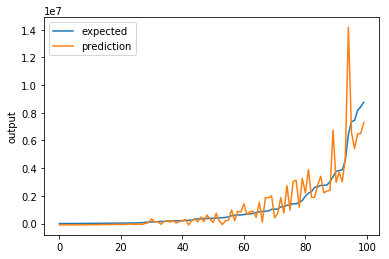

In [116]:
#Linear Regression
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
#XTrain, XTest, YTrain, YTest = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
liReg_pred = regr.predict(x_test)

print('Coefficients: \n', regr.coef_)
score = np.sqrt(metrics.mean_squared_error(liReg_pred,y_test))
print("Final score (RMSE): {}".format(score))
print('Variance score: %.2f' % r2_score(y_test, liReg_pred))
# Plot the chart
chart_regression(liReg_pred.flatten()[0:100],y_test[0:100])